In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import csv
import json

import matplotlib.pyplot as plt

from scipy import interpolate

## Variables
These variables may change:

In [2]:
basedir = "/mnt/adata9/"
# basedir = "/adata_pool/"
# basedir = "/mnt/adata11/"
# basedir = "/adata_clust/"

animal_name='JC274'
date='20220306'

# # JC258 - 24 tetrodes
# num_tetrodes=24 (total number of tetrodes, not last par index)
# last_pfc_left=8 # index of last tetrode plus 1
# last_pfc_right=15

# # JC267
# num_tetrodes=27
# last_pfc_left=8 # index of last tetrode plus 1
# last_pfc_right=14

# # JC274
# num_tetrodes=25
# last_pfc_left=8 # index of last tetrode plus 1
# last_pfc_right=14
# reward_arms=[3,7]

# # JC283 - 30 tetrodes
# num_tetrodes=30
# last_pfc_left=8 # index of last tetrode plus 1
# last_pfc_right=16
# reward_arms=[2,7]

# # JC283 - 25 tetrodes
# num_tetrodes=25
# last_pfc_left=8 # index of last tetrode plus 1
# last_pfc_right=16
# reward_arms=[2,7]

# # JC315
# num_tetrodes=32
# last_pfc_left=8 # index of last tetrode plus 1
# last_pfc_right=16
# reward_arms=[3,8]

# session_idx=[[1],[2],[3],[4,5],[6]]
# session_idx=[[1,2],[3],[4]]

# session_names=['presleep','training1','intersleep','training2','postsleep']
# session_names=['training1','intersleep','training2']

# Possible brain regions and cell types
brain_regions = ['1', 'p', 'r', 'o', 'c']
cell_types = ['b', 'p']

These variables do not change:

In [3]:
sample_rate_res_old=24000

sample_rate_whl=39.0625
sample_rate_res=20000

sample_rate_eegh=5000

downsampled_res=sample_rate_res/sample_rate_res_old

starting_cell_ind=2

basename = animal_name+'-'+date
mbasedir="/adata_pool/merged/"+basename+'/'

## Import session metadata

In [4]:
session_metadata = {}
with open('session_metadata.csv', mode='r', encoding='utf-8') as file:
    reader = csv.DictReader(file, delimiter=";")    
    for line in reader:
        session_id = line.pop('session_id')
        session_metadata[session_id] = line

In [5]:
session_metadata[basename]

{'num_tetr': '25',
 'last_pfc_left': '8',
 'last_pfc_right': '14',
 'session_names': "['training1','intersleep','training2']",
 'session_idx': '[[1,2],[3],[4,5,6,7]]',
 'reward_arms': '7,3',
 'rewards': 'C,H'}

In [6]:
num_tetrodes = int(session_metadata[basename]['num_tetr'])

session_idx = json.loads(session_metadata[basename]['session_idx'])

session_names_str = session_metadata[basename]['session_names']
session_names_str = session_names_str.replace("'",'"') # the single quotes aren't being read in JSON, but I can't use " in the csv because it's a str delimiter
session_names = json.loads(session_names_str)

last_pfc_left = int(session_metadata[basename]['last_pfc_left'])
last_pfc_right = int(session_metadata[basename]['last_pfc_right'])

## Des file generation
The des file contains information about the neuron type and the brain area. The des_full file contains information about the brain hemisphere.

In [7]:
# If the merged animal directory does not exist, create it
if not os.path.isdir(mbasedir):
        os.makedirs(mbasedir)

# I think this should be deleted:
# # Create a directory for this session
# mfolder=basedir+animal_name+'/m'+animal_name+'-'+date+'/'

# Initialize the output res, clu, and des variables
res=np.zeros([0])
clu=np.zeros([0])
des=[]

des_full=[]

for tet_i in range(num_tetrodes):
    print("Processing tet"+str(tet_i))
    folder=basedir+"processing/"+animal_name+'/'+date+'/sorted/tet'+str(tet_i)+'/phy_export/'
    
    # If tetrode folder exists, continue:
    if os.path.isdir(folder)==True:
        
        # Load phy spike clusters and times
        spike_clusters=np.load(folder+'spike_clusters.npy')
        spike_times=np.load(folder+'spike_times.npy')

        # Load information about clusters (whether good, noise, or mua)
        good_noise=pd.read_csv(folder+'cluster_group.tsv',sep='\t').to_numpy()

        good_ind=np.zeros([0])
        mua_ind=np.zeros([0])
        ###################################
        print("Length of mua_ind before loop:", len(mua_ind))

        # Iterate over clusters and keep good and mua clusters
        for i in range(good_noise.shape[0]):
            if good_noise[i,1]=='good' or good_noise[i,1]=='mua':
                neurontype=pd.read_csv(folder+'cluster_neurontype.tsv',sep='\t').to_numpy()
                good_ind=np.append(good_ind,good_noise[i,0])
                if good_noise[i,1]=='mua':
                    mua_ind=np.append(mua_ind,1)
                else:
                    mua_ind=np.append(mua_ind,0)
                    
#         ### Shaurya's edit
#         ### I THINK IT SHOULD BE THIS              
#         # Iterate over clusters and keep good and mua clusters
        
        
#         for i in range(good_noise.shape[0]):
#             if good_noise[i,1]=='good':
#                 neurontype=pd.read_csv(folder+'cluster_neurontype.tsv',sep='\t').to_numpy()
#                 good_ind=np.append(good_ind,good_noise[i,0])
#             elif good_noise[i,1]=='mua':
#                 mua_ind=np.append(mua_ind,1)
#             else:
#                 mua_ind=np.append(mua_ind,0)
#         print(good_ind)
#         print(mua_ind)
        # For good clusters, export neuron type label to des file and brain area to des_full
        for cell_i in range(len(good_ind)):
            cluster_idx = np.where(neurontype[:,0] == good_ind[cell_i])
            print(neurontype[cluster_idx,1])
            cluster_label=neurontype[cluster_idx,1][0][0]
            cell_type = cluster_label[0]
            
            # Make sure the cell label makes sense and append to des
            if (
                cluster_label[0] in cell_types
                and cluster_label[1] in brain_regions
                and len(cluster_label)==2
                ):
                
                des.append(cluster_label)
                
                # Append to des_full based on brain region
                if tet_i<last_pfc_left:
                    des_full.append('pfc_left')
                elif tet_i<last_pfc_right:
                    des_full.append('pfc_right')
                else:
                    des_full.append('hpc_right')
                    
            else:
                print('Check label for cluster', cell_i)
                break

            res_t=spike_times[spike_clusters==good_ind[cell_i]]
            clu_t=starting_cell_ind*np.ones(len(res_t))
            
            print("Current cell_i:", cell_i)
            
            if mua_ind[cell_i]==1:
                clu_t=np.ones(len(clu_t))

            res=np.append(res,res_t)
            clu=np.append(clu,clu_t)

            starting_cell_ind=starting_cell_ind+1

    else:
        print('Tetrode folder missing')

Processing tet0
Length of mua_ind before loop: 0
Processing tet1
Length of mua_ind before loop: 0
[['pp']]
Current cell_i: 0
Processing tet2
Length of mua_ind before loop: 0
Processing tet3
Length of mua_ind before loop: 0
[['pp']]
Current cell_i: 0
[['pp']]
Current cell_i: 1
[['pp']]
Current cell_i: 2
[['pp']]
Current cell_i: 3
[['pp']]
Current cell_i: 4
[['pp']]
Current cell_i: 5
[['pp']]
Current cell_i: 6
[['pp']]
Current cell_i: 7
[['pp']]
Current cell_i: 8
[['pp']]
Current cell_i: 9
[['pp']]
Current cell_i: 10
Processing tet4
Length of mua_ind before loop: 0
Processing tet5
Length of mua_ind before loop: 0
[['pp']]
Current cell_i: 0
[['pp']]
Current cell_i: 1
[['pp']]
Current cell_i: 2
[['pp']]
Current cell_i: 3
[['pp']]
Current cell_i: 4
[['pp']]
Current cell_i: 5
[['pp']]
Current cell_i: 6
Processing tet6
Length of mua_ind before loop: 0
[['pp']]
Current cell_i: 0
[['pp']]
Current cell_i: 1
Processing tet7
Length of mua_ind before loop: 0
[['pp']]
Current cell_i: 0
[['pp']]
Curr

## Resampling and interpolating of the whl file

In [8]:
# Load the timestamps for each recording
session_timestamps=np.loadtxt(basedir+"processing/"+animal_name+'/'+date+'/'+'session_shifts.txt')
session_timestamps=np.append([0],session_timestamps) # start the first timestamp at 0

# Load the whl file and interpolate
df = pd.read_csv(basedir+"processing/"+animal_name+'/'+date+'/'+date+'.whl',
                                        sep=' ', header=None, names=['dim1', 'dim2', 'dim1_2', 'dim2_2', 'timestamp','valid'])

whl_old=pd.DataFrame(df).to_numpy()
length_time_whl=whl_old.shape[0]/50/60/60

len_session=session_timestamps[-1]
length_time=len_session/sample_rate_res_old/60/60

data_points_len=(len_session)/whl_old.shape[0]
sample_rate_whl_old=data_points_len/sample_rate_res_old

sample_rate_whl_old=1/sample_rate_whl_old


x_old=np.linspace(0,len_session,whl_old.shape[0])
x_new=np.linspace(0,len_session,int(whl_old.shape[0]/sample_rate_whl_old*sample_rate_whl))

whl_new=np.zeros([len(x_new),2])

# dim1
f = interpolate.interp1d(x_old, whl_old[:,0])
y_new=f(x_new)
whl_new[:,0] = f(x_new)

# dim2
f = interpolate.interp1d(x_old, whl_old[:,1])
whl_new[:,1] = f(x_new)

# replace missing timestamps with -1
index_bad_new=np.zeros(len(x_new))
for i in range(whl_old.shape[0]):
    if whl_old[i,0]==1023:
        i_new=int(i/sample_rate_whl_old*sample_rate_whl)
        if i_new+1>len(index_bad_new)-1:
            index_bad_new[i_new-1:i_new]=1
        else:
            index_bad_new[i_new-2:i_new+2]=1

whl_new[index_bad_new>0,:]=1023

# I don't know what this line is, Vlad had it commented out
# np.savetxt(mfolder+animal_name+'-'+date+'_'+str(session_i)+'.whl', whl_new.astype(int), fmt='%i')

## Whl, res and clu file splitting
Splitting according to session type

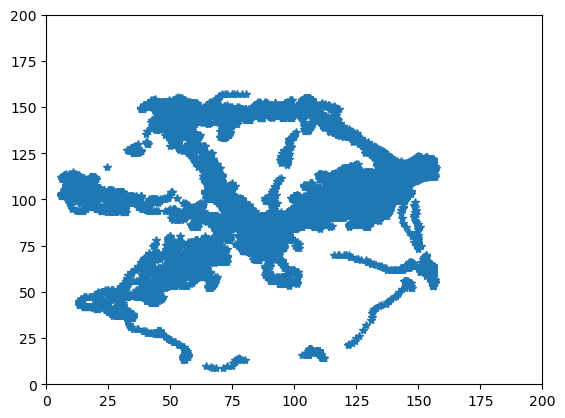

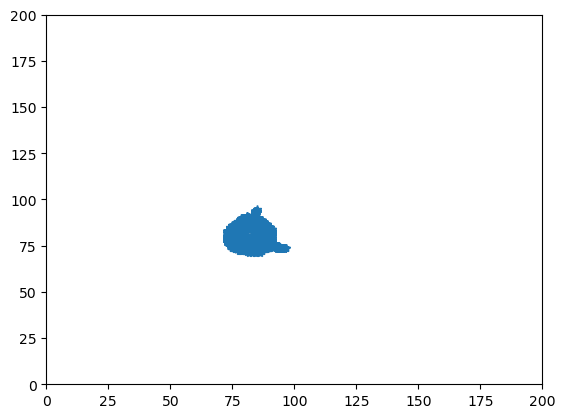

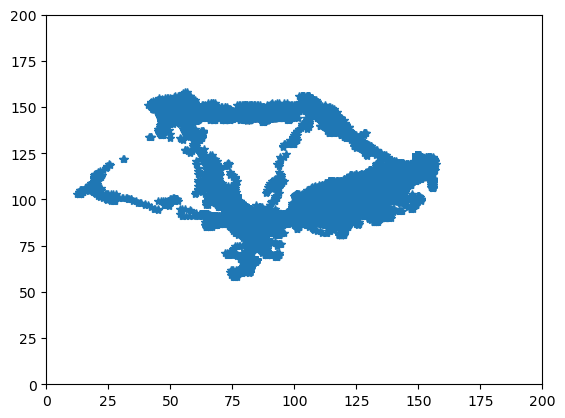

In [9]:
sort_arg=np.argsort(res)

res=res[sort_arg]
clu=clu[sort_arg]

res_down=res*downsampled_res
session_timestamps_down=session_timestamps*downsampled_res


for i in range(len(session_idx)):

    # Return the first and last recording of a session type
    if len(session_idx[i])>0:
        start_cut=session_idx[i][0]-1
        end_cut=session_idx[i][-1]

        index1=res_down<session_timestamps_down[end_cut]
        index2=res_down>session_timestamps_down[start_cut]
        #test=np.logical_and(index1,index2)
        clu_temp=clu[np.logical_and(res_down<session_timestamps_down[end_cut],res_down>session_timestamps_down[start_cut])]
        res_temp=res_down[np.logical_and(res_down<session_timestamps_down[end_cut],res_down>session_timestamps_down[start_cut])]

        res_temp=res_temp-session_timestamps_down[start_cut]
        clu_temp = np.insert(clu_temp, 0, starting_cell_ind, axis=0)

        np.savetxt(mbasedir+animal_name+'-'+date+'_'+session_names[i]+'.res', res_temp.astype(int), fmt='%i')
        np.savetxt(mbasedir+animal_name+'-'+date+'_'+session_names[i]+'.clu', clu_temp.astype(int), fmt='%i')

        start_whl=int(session_timestamps_down[start_cut]/sample_rate_res*sample_rate_whl)
        end_whl=int(session_timestamps_down[end_cut]/sample_rate_res*sample_rate_whl)
        whl_temp=whl_new[start_whl:end_whl]

        np.savetxt(mbasedir+animal_name+'-'+date+'_'+session_names[i]+'.whl', whl_temp.astype(int), fmt='%i')

        plt.plot(whl_temp[:,0],whl_temp[:,1],'*')
        plt.xlim([0,200])
        plt.ylim([0,200])
        plt.show()



with open(mbasedir+animal_name+'-'+date+'.des', 'w') as fp:
    fp.write('\n'.join(des))

with open(mbasedir+animal_name+'-'+date+'.des_full', 'w') as fp:
    fp.write('\n'.join(des_full))